# Case Study 1

In this case study we will investigate a quantum mechanical particle confined in a one-dimensional box. In the first part we will use Gaussian process regression to learn the ground state wavefunction from a Bayesian inference perspective. In the second part we will instead variationally optimize the ground state using the Gaussian process as a wavefunction ansatz.

### Bayesian learning of the wavefunction with a Gaussian process

In [1]:
# import libraries
import random
import numpy as np
import matplotlib.pyplot as plt

Without loss of generality, we can set the length of the box to 5.

In [2]:
# define the box size
L = 5

The analytical solution for this simple system is known, and here we define two functions returnig the exact ground state wavefunction amplitude and the exact energy.

In [3]:
# exact wavefunction
def psi_exact(x, L):
    return np.sqrt(2/L) * np.sin(np.pi*x/L)

# exact energy
def E(L):
    return np.pi**2/(2*L**2)

Using the function `psi_exact`, we can genereate the training set from which the GP will learn the functional form of the ground state. As explained in the main text, we can start by generating the training points $\{x^{(i)}\}_{i=1}^{N_{tr}}$ in a random fashion, but we need to remember to include the two points at the edges of the box to ensure the proper boundary conditions. At the same time, we can also create an array containing the exact amplitudes, that is, the vector $\boldsymbol{\Psi}$ with elements $\Psi_i = \Psi(x^{(i)})$.

In [4]:
# define a function that takes as input the total number of desired training
# points and the length of the box, and returns two numpy arrays containing
# the values x_tr of the training points and the associated exact amplitudes y_tr.
# Note that N_tr should be at least 3, because two points are the boundaries,
# and at least one point within the box is needed to get meaningful results!
def random_training_set(N_tr, L):
    # check that N_tr is at least 3
    assert N_tr > 2
    
    # initialize the list of training points with the boundaries
    x_tr = [0.0, float(L)]
    # add the randomly generated ones
    x_tr = x_tr + [random.uniform(0,L) for i in range(N_tr-2)]
    # check that we have the correct number of training points
    assert len(x_tr) == N_tr
    # and sort the list, just for convenience
    x_tr.sort()
    
    # generate the exact wavefunction amplitudes
    y_tr = [psi_exact(x, L) for x in x_tr]
    
    # return x_tr and y_tr as numpy arrays
    return np.array(x_tr),np.array(y_tr)

We start with the smallest possible training set that makes sense, that is, one with 3 points: two at the boundaries and one within the box.

In [5]:
# generate the training set
N_tr = 3
x_tr,y_tr = random_training_set(N_tr, L)

# inspect the created training set
print('Training set positions:  ',x_tr)
print('Training set amplitudes: ',y_tr)

Training set positions:   [0.         2.68668831 5.        ]
Training set amplitudes:  [0.00000000e+00 6.28109470e-01 7.74534643e-17]


The Gaussian process within the box is defined as

$$
\Phi_{GP}(x) = \sum_{i=1}^{N_{tr}} w_i k(x^{(i)},x)
$$

In the following, we define the kernel $k(x,x')$ as the squared exponential function with an $l = 1.0$.

In [6]:
# define the squared exponential kernel
def kernel(x, x_prime, l):
    return np.exp(-0.5 * (x - x_prime)**2 / l**2)

# set the l value to 1.0
l = 2.0

Next, we create a function that generates the covariance matrix $\mathbf{K}$, by evaluating the kernel between all training set points. It is convenient for later to create a general function that computes the covariance between two general sets of points `xn` and `xn_prime` that can have different dimensions.

In [7]:
# evaluate the squared exponential kernel between two sets of points
def covariance(xn, xn_prime, l):
    return np.array([[kernel(xi,xj,l) for xj in xn_prime] for xi in xn])

# compute the covariance matrix for the training set
K_tr = covariance(x_tr, x_tr, l)

# check the shape, it should be N_tr x N_tr
print('Covariance matrix dimension: ', K_tr.shape)

Covariance matrix dimension:  (3, 3)


At this point, we already have all ingredients to calculate the optimal weights of the GP with $\mathbf{w} = (\mathbf{K} + \lambda\mathbf{1})^{-1}\boldsymbol{\Psi}$. To invert the covariance matrix we use the `solve` function from the numpy library. For such a small training set, we can safely set $\lambda = 0$, which means that the GP is an exact interpolator, and will pass throguh the exact amplitudes of the training set.

In [8]:
# set lambda equal zero
λ = 0.0

# compute the optimal weights
w = np.linalg.solve(K_tr + np.eye(N_tr,N_tr)*λ, y_tr)

To visualize the function learned by the GP, we should first create an array of prediction points $\{\tilde{x}^{(i)}\}$ at which we can compute the predicted value of the GP (and of the exact wavefunction for comparison).

In [9]:
# define a set of equally spaced points at a distance dx between each other
dx = 0.01
# total number of prediction points
N_pr = int(L/dx) + 1
# generate the points
x_pr = np.linspace(0,L,N_pr)
# obtain the exact value of the wave function at the prediction points
y_pr = np.array([psi_exact(x,L) for x in x_pr])

Now, we need to evaluate the kernel function between all training and prediction points. This step corresponds to computation of $k(x^{(i)},x)$ in our ansatz, where $x$ is taken at the prediction points $\{\tilde{x}^{(i)}\}$.
The vector of functions $\mathbf{k}(x)$, with elements $\mathbf{k}_i(x) = k(x^{(i)},x)$ is also called covariance vector.

In [10]:
# compute the covariance vector at all prediction points
k_pr = covariance(x_tr, x_pr, l)

# check the shape, should be N_tr x N_pr
print('Covariance vector dimension: ', k_pr.shape)

Covariance vector dimension:  (3, 501)


Finally, compute the Gaussian process prediction!

In [11]:
# compute the GP at the prediction points
gp_pr = np.transpose(w) @ k_pr

As explained in the chapter, one can estimate the uncertainty in the prediction with the square root of the variance, that is

$$
\sigma(x) = \sqrt{k(x,x) - \mathbf{k}(x)^T (\mathbf{K} + \lambda\mathbf{1})^{-1} \mathbf{k}(x)}
$$

To know the uncertainty of `gp_pr`, we need to compute $\sigma(x)$ at all prediction points.

In [12]:
# first compute the covariance matrix for the prediction set
K_pr = covariance(x_pr, x_pr, l)

# then compute K^-1*k_pr
W = np.linalg.solve(K_tr + np.eye(N_tr,N_tr)*λ, k_pr)

# compute square root of variance (sigma) at prediction points
# clip the function to avoid numerical instabilities
s_pr = np.sqrt(np.clip(np.diag(K_pr - np.transpose(k_pr) @ W), 0.0, None))

Plot the GPWF along with the exact ground state wavefunction for visual inspection.

In [13]:
# function that plots everything: exact solution, GP prediction, uncertainty and training points
def make_plot(x_tr = x_tr,
              y_tr = y_tr,
              x_pr = x_pr,
              y_pr = y_pr,
             gp_pr = gp_pr,
              s_pr = s_pr,
                 L = L   ):
    
    # initialize figure
    plt.figure(figsize=(14, 8))

    # set x ranges and tics
    plt.xlim([-0.1, L+0.1])
    plt.xlabel('$x$', fontsize=14)
    plt.xticks(fontsize=14)

    # set y ranges and tics
    plt.ylabel('$y$', fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim([-1.0, 2.0])

    # plot x axis
    plt.hlines(0,0,L, color='gray')

    # plot the potential wall
    plt.axvline(0, color='k')
    plt.axvline(L, color='k')
    plt.axvspan( L, L+1, alpha=0.2, color='gray')
    plt.axvspan(-1,   0, alpha=0.2, color='gray')

    # plot the exact wavefunction
    plt.plot(x_pr, y_pr, 'b--', label='$\Psi(x)$')
    # plot the gaussian process
    plt.plot(x_pr, gp_pr, 'orange', lw=2, label='$\Phi_{GP}(x)$')
    # plot uncertainty of GP (2*sigma ~ 95%)
    plt.fill_between(x_pr, gp_pr-2*s_pr, gp_pr+2*s_pr, color='orange',alpha=0.15, label='')
    # plot the training points
    plt.plot(x_tr, y_tr, 'ko', linewidth=2, label='$(x^{(i)}, \Psi_i)$')

    # show the plot and legend
    plt.legend(fontsize=15, ncol = 3)
    plt.show()

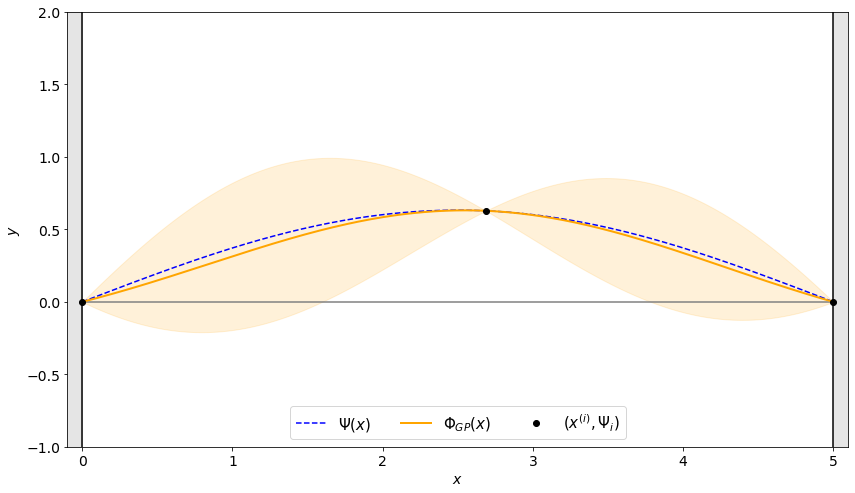

In [14]:
# plot the Gaussian process!
make_plot()

To evaluate the accuracy of the prediction, we will compute the mean squared error of the wavefunction at the prediction points.

In [15]:
# define the mean squared error
def mse(x, y):
    return sum(abs(x - y)**2)/len(x)

In [16]:
# compute the MSE between the prediction and the exact function
print('MSE: ', mse(y_pr, gp_pr))

MSE:  0.0010422204347570242


It is now convenient to wrap all steps above into a single function that, provided with the number of training points, the $l$ value and a few other parameters, generates a new GP wavefunction.

In [17]:
# function to generate a set of N_tr random points and fit
# a Gaussian process with squared exponential kernel, with
# defined l value, for the particle in a box of length L,
# predicted at a grid with equal space dx between the points.
def random_GP(N_tr, l, L, λ, dx):
    
    # generate the random training set
    x_tr,y_tr = random_training_set(N_tr, L)
    np.savetxt('training_set.csv', np.column_stack((x_tr,y_tr)), fmt='%10.8f')
    
    # generate the prediction set
    N_pr = int(L/dx) + 1
    x_pr = np.linspace(0, L, N_pr)
    y_pr = np.array([psi_exact(x, L) for x in x_pr])
    
    # covariance matrix for training set
    K_tr = covariance(x_tr, x_tr, l)
    
    # covariance vector
    k_pr = covariance(x_tr, x_pr, l)
    
    # to save some computation, we only need W and not w
    # w = np.linalg.solve(K_tr,y_tr)
    # gp_pr = np.transpose(w) @ k_tr
    
    # invert covariance matrix
    W = np.linalg.solve(K_tr + np.eye(N_tr,N_tr)*λ, k_pr)

    # get the gp
    gp_pr = np.transpose(W) @ y_tr
    
    # covariance matrix for the prediction set
    K_pr = covariance(x_pr, x_pr, l)

    # then compute K^-1*k_pr
    W = np.linalg.solve(K_tr, k_pr)

    # compute square root of variance (sigma) at prediction points
    # clip numerical noise
    s_pr = np.sqrt(np.clip(np.diag(K_pr - np.transpose(k_pr) @ W), 0.0, None))
    
    np.savetxt('prediction_set.csv', np.column_stack((x_pr,y_pr,gp_pr,s_pr)), fmt='%10.8f')
    
    # compute mse
    gp_mse = mse(y_pr, gp_pr)
    
    # plot the results
    make_plot(x_tr, y_tr, x_pr, y_pr, gp_pr, s_pr, L)
    
    # print out MSE
    print('MSE: ', gp_mse)
    
    # return the gp, the undertainty and the mse
    return gp_pr, s_pr, gp_mse

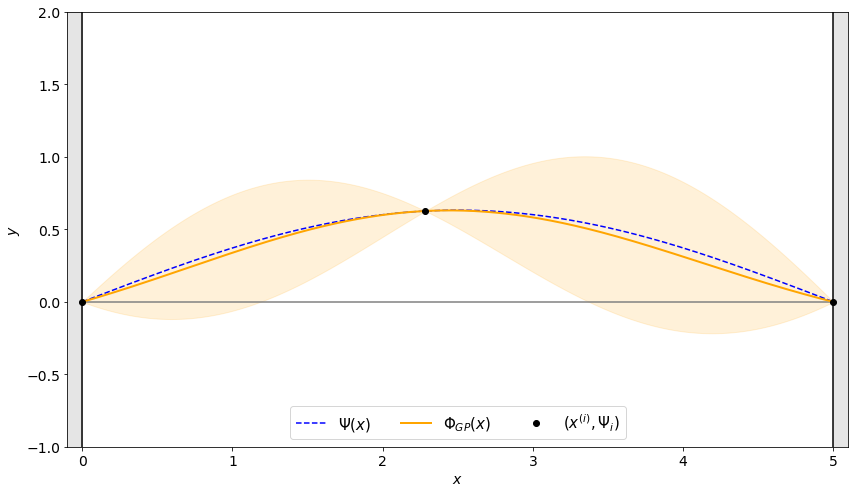

MSE:  0.0010798462441313484


In [18]:
# try to play around with the number of training points and the l value
random_GP(N_tr = 3, l = 2.0, L = 5, λ = 0.0, dx = 0.01);

Let us now generate some equidistant training points.

In [19]:
# return equidistant training points and exact amplitudes
def equidistant_training_set(N_tr, L):
    # check that N_tr is at least 3
    assert N_tr > 2
    # generate equidistant points
    x_tr = np.linspace(0, L, N_tr)
    # generate the exact wavefunction amplitudes
    y_tr = [psi_exact(x, L) for x in x_tr]
    
    # return x_tr and y_tr as numpy arrays
    return x_tr,np.array(y_tr)

In [20]:
# function to generate a set of N_tr random points and fit
# a Gaussian process with squared exponential kernel, with
# defined l value, for the particle in a box of length L,
# predicted at a grid with equal space dx between the points.
def equidistant_GP(N_tr, l, L, λ, dx):
    
    # generate the equidistant training set
    x_tr,y_tr = equidistant_training_set(N_tr, L)
    
    # generate the prediction set
    N_pr = int(L/dx) + 1
    x_pr = np.linspace(0, L, N_pr)
    y_pr = np.array([psi_exact(x, L) for x in x_pr])
    
    # covariance matrix for training set
    K_tr = covariance(x_tr, x_tr, l)
    
    # covariance vector
    k_pr = covariance(x_tr, x_pr, l)
    
    # invert covariance matrix
    W = np.linalg.solve(K_tr + np.eye(N_tr,N_tr)*λ, k_pr)

    # get the gp
    gp_pr = np.transpose(W) @ y_tr
    
    # covariance matrix for the prediction set
    K_pr = covariance(x_pr, x_pr, l)

    # then compute K^-1*k_pr
    W = np.linalg.solve(K_tr, k_pr)

    # compute square root of variance (sigma) at prediction points
    # clip numerical noise
    s_pr = np.sqrt(np.clip(np.diag(K_pr - np.transpose(k_pr) @ W), 0.0, None))
    
    # compute mse
    gp_mse = mse(y_pr, gp_pr)
    
    # plot the results
    make_plot(x_tr, y_tr, x_pr, y_pr, gp_pr, s_pr, L)
    
    # print out MSE
    print('MSE: ', gp_mse)
    
    # return the gp, the uncertainty and the mse
    return gp_pr, s_pr, gp_mse

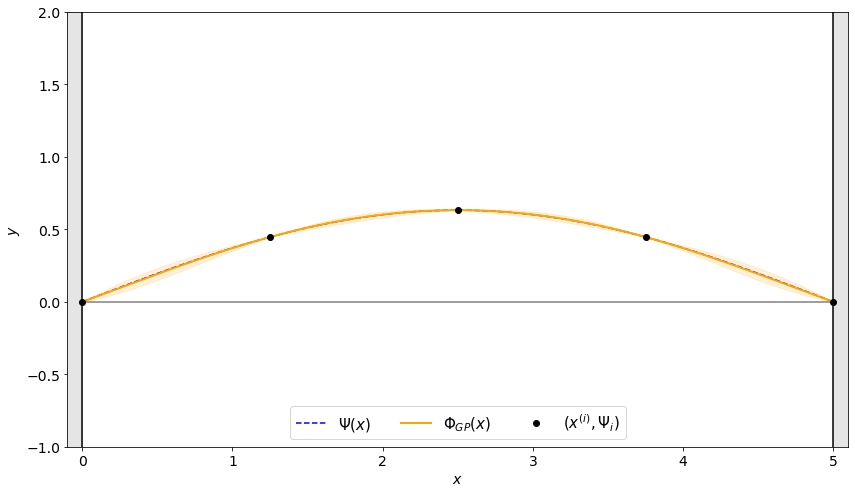

MSE:  3.5173312672192767e-06


In [21]:
# try different values of N_tr and l
equidistant_GP(N_tr = 5, l = 2.0, L = 5, λ = 0.0, dx = 0.01);

### Variational optimization of the Gaussian process wavefunction

In the second part of this case study we are going to optimize the Gaussian process wavefunction variationally.
We start by incorporating explicitly the boundary conditions in our ansatz, that is

$$
\tilde{\Psi}(x) = \Phi_{GP}(x)f(x)
$$

where $f(x) = x(L-x)$.

To evaluate the energy expectation value with $\tilde{\Psi}$ we need to compute the overlap and Hamiltonian
matrix elements as explained in the main text.
To do that, we need to know the action of the Hamiltonian on the ket functions

$$
\begin{aligned}
\hat{H}(k(x^{(j)},x)f(x)) &= -\frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}x^2} k(x^{(j)},x)f(x) \\
&= -\frac{1}{2} (k''(x^{(j)},x)f(x) + 2k'(x^{(j)},x)f'(x) + k(x^{(j)},x)f''(x))
\end{aligned}
$$

Hence, we need to analytically derive the expressions of the first and second derivatives of the kernel and the boundary conditions. This is left as an exercise, and in the following we will directly provide the implementation of those functions. 

In [22]:
# define boundary conditions
def f(x, L):
    return x*(L-x)

# 1st-order derivative of f(x)
def df(x, L):
    return L - 2.0*x

# 2nd-order derivative of f(x)
def d2f(x, L):
    return -2.0

In the following we do the same for the kernel. For convenience, we redefine/rename the kernel function from above and simply call it `k(...)`, which provides more compact definitions later on.

In [23]:
# re-define the squared exponential kernel
def k(xi, x, l):
    return np.exp(-0.5 * (xi - x)**2 / l**2)

# 1st-order derivative of the kernel with respect to x
def dk(xi, x, l):
    return (xi - x)/l**2 * k(xi, x, l)

# 2nd-order derivative of the kernel with respect to x
def d2k(xi, x, l):
    return (1.0/l**4 * (xi - x)**2 - 1.0/l**2) * k(xi, x, l)

With the knowledge of the derivatives, we can now define functions that compute the overlap and Hamiltonian matrix elements

$$
S_{ij} = \int k(x^{(i)},x)f(x) k(x^{(j)},x)f(x) \mathrm{d}x
$$

and

$$
H_{ij} = \int -\frac{1}{2} k(x^{(i)},x)f(x) (k''(x^{(j)},x)f(x) + 2k'(x^{(j)},x)f'(x) + k(x^{(j)},x)f''(x)) \mathrm{d}x
$$

We start by defining functions that compute the *integrands* at points $x$.

In [24]:
# compute the integrand for an overlap matrix element
def overlap(x, xi, xj, l, L):
    return f(x, L)**2 * k(xi, x, l) * k(xj, x, l)

# compute the integrand for a Hamiltonian matrix element
# (this is only the kinetic energy, hence is called kinetic(...))
def kinetic(x, xi, xj, l, L):
    return -0.5*f(x, L)*k(xi, x, l)*(d2f(x, L)*k(xj, x, l) + 2.0*df(x, L)*dk(xj, x, l) + f(x, L)*d2k(xj, x, l))

We are almost done. To compute the matrix elements we integrate the functions just defined with the `scipy.integrate.quad` function of the scipy library. As usual, it is convenient to wrap the creation of the overlap and Hamiltonian matrices into separate functions that we can simply call later on.

In [25]:
# import library
from scipy import integrate

# compute the overlap matrix for a given training set
def make_S(x_tr, l, L):
    # initialize overlap matrix
    N_tr = len(x_tr)
    S = np.zeros((N_tr,N_tr))
    
    for i,xi in enumerate(x_tr):
        for j,xj in enumerate(x_tr):
            S[i,j],err = integrate.quad(overlap, 0, L, args=(xi,xj,l,L))
            
    return S


# compute the overlap matrix for a given training set
def make_H(x_tr, l, L):
    # initialize Hamiltonian matrix
    N_tr = len(x_tr)
    H = np.zeros((N_tr,N_tr))
    
    for i,xi in enumerate(x_tr):
        for j,xj in enumerate(x_tr):
            H[i,j],err = integrate.quad(kinetic, 0, L, args=(xi,xj,l,L))
            
    return H


As shown in the main text, the energy expectation value can be calculated as a dot product between the GP weights and the Hamiltonian and overlap matrices.

In [26]:
# compute the energy of the GP wavefunction ansatz
def energy(w, x_tr, l, L):
    S = make_S(x_tr, l, L)
    H = make_H(x_tr, l, L)
    
    wSw = np.dot(np.dot(w,S),w)
    wHw = np.dot(np.dot(w,H),w)
    
    return wHw/wSw

We can test our implementation by randomly generating a set of weights, have a look at the resulting GP wavefunction, and then compare its energy with respect to the exact one.

In [27]:
# (re-)set the number of desired training points
N_tr = 3

# generate a random training set
x_tr,y_tr = random_training_set(N_tr, L)

# generate random weights for the GP wavefunction
w = np.random.rand(N_tr)

# energy associated to the GP wavefunction
E_rnd = energy(w, x_tr, l, L)
print('Energy with random weights: ', E_rnd)

# energy associated to the exact wavefunction
print('Energy of exact solution: ', E(L))

# compute the difference
print('Energy difference: ', E_rnd - E(L))

Energy with random weights:  0.23376967686280378
Energy of exact solution:  0.19739208802178715
Energy difference:  0.036377588841016634


It is convenient to define a function that returns the GP wavefunction and uncertainty evaluated at the prediction points, such that we can plot it with `make_plot(...)` from before.

In [28]:
# return the normalized GP multiplied by the function f(x) evaluated at x_pr
# and the associated uncertainty of the GP
def gpwf(x_pr, x_tr, w, l, L):
    # compute covariance vector
    k_pr = covariance(x_tr, x_pr, l)
    # compute the GP with the given weights from the input
    gp_pr = np.transpose(w) @ k_pr
    # compute the covariance matrix for both training and prediction sets
    K_tr = covariance(x_tr, x_tr, l)
    K_pr = covariance(x_pr, x_pr, l)
    # compute K^-1*k_pr
    W = np.linalg.solve(K_tr, k_pr)
    # compute square root of variance (sigma) at prediction points
    s_pr = np.sqrt(np.clip(np.diag(K_pr - np.transpose(k_pr) @ W), 0.0, None))
    
    # compute the boundary conditions on the prediction points
    f_pr = np.array([f(x,L) for x in x_pr])
    
    # compute overlap for normalization of the weights
    S = make_S(x_tr, l, L)
    wSw = np.dot(np.dot(w,S),w)
    
    # compute the (absolute value of the ) gpwf
    # this ensures that the amplitudes are positive
    # even if the phase is negative
    gpwf_pr = np.abs((f_pr * gp_pr)/np.sqrt(wSw))
    
    return gpwf_pr, s_pr

Let us now compute the GP wavefunction at the training and prediction points, and plot the result.

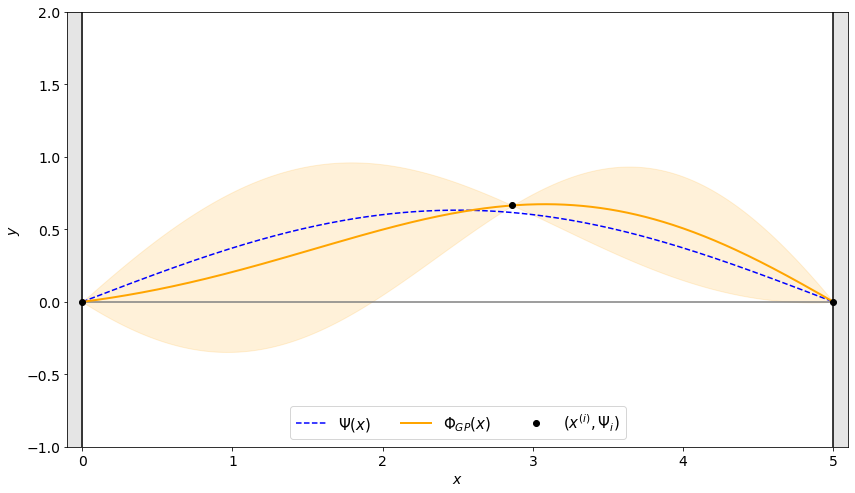

In [29]:
# gpwf at the training points, needed for plotting
gpwf_tr,s_tr = gpwf(x_tr, x_tr, w, l, L)
# gpfw at the prediction points
gpwf_pr,s_pr = gpwf(x_pr, x_tr, w, l, L)
# plot!
make_plot(x_tr, gpwf_tr, x_pr, y_pr, gpwf_pr, s_pr, L)

We are now ready for the last step and optimize the weights defining the Gaussian process wavefunction. As explained in the main text, the minimization of the expectation value with respect to the weights corresponds to solving a generalized eigenvalue problem with the Hamiltonian and overlap matrices. Hence, we need to explicitly construct these matrices, and then obtain the eigensolution using `scipy.linalg.eigh`.

In [30]:
# import module
from scipy import linalg

In [31]:
# construct Hamiltonian and overlap matrices
S = make_S(x_tr, l, L)
H = make_H(x_tr, l, L)

# solve the generalized eigenvalue problem
E_opt,w_opt = linalg.eigh(H,S)

Where `E_opt` and `w_opt` contain the ground state solution, but also a few excited states (in total `N_tr` states).
We can now see the energy difference between the exact solution and the variationally optimized GP wavefunction.

Important: if the number of training configurations is too large (approximately starting from 8 training configurations for a box of size $L=5$), linear dependencies may give unphyiscal results or simply fail the diagonalization of the Hamiltonian.

In [32]:
# energy associated to the optimized GP wavefunction
print('Energy of GP wavefunction: ', E_opt[0])
# note that E_opt[0] sould be the same as
# energy(w[:,0], x_tr, l, L))

# energy associated to the exact wavefunction
print('Energy of exact solution: ', E(L))

# compute the difference
print('Energy difference: ', E_opt[0] - E(L))

Energy of GP wavefunction:  0.19742337073834043
Energy of exact solution:  0.19739208802178715
Energy difference:  3.128271655328252e-05


As before, we can plot the GP wavefunction and see how it differs from the initial (random) one.

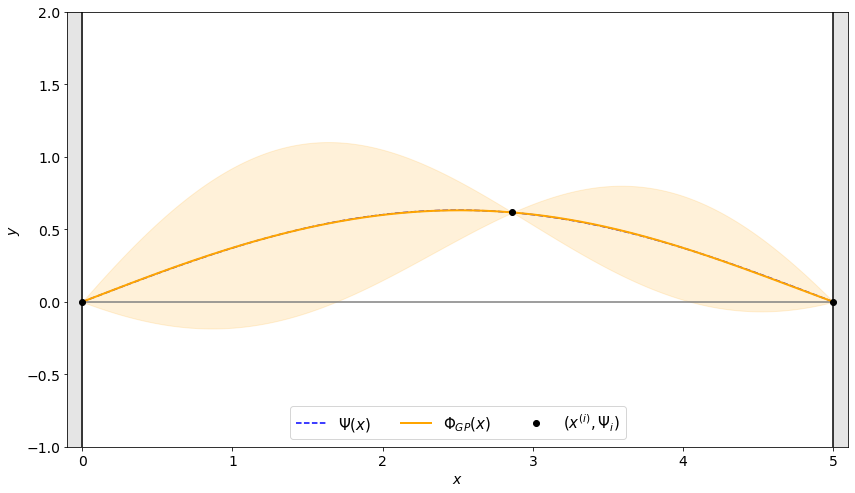

In [33]:
# get optimized GP wavefunction at training and prediction points
gpwf_tr,s_tr = gpwf(x_tr, x_tr, w_opt[:,0], l, L)
gpwf_pr,s_pr = gpwf(x_pr, x_tr, w_opt[:,0], l, L)
# plot it!
make_plot(x_tr, gpwf_tr, x_pr, y_pr, gpwf_pr, s_pr, L)